In [1]:
import joblib
import javalang
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import javalang
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter


In [2]:

# Function to read a Java file and return its content as a string
def read_java_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

# Function to extract AST nodes from Java code
def extract_ast_nodes(code):
    try:
        tokens = list(javalang.tokenizer.tokenize(code))
        parser = javalang.parser.Parser(tokens)
        tree = parser.parse()

        ast_nodes = []
        for path, node in tree:
            if isinstance(node, javalang.tree.Node):
                ast_nodes.append(node.__class__.__name__)
        return ' '.join(ast_nodes)
    except (javalang.parser.JavaSyntaxError, javalang.tokenizer.LexerError) as e:
        print(f"Error parsing Java code: {e}")
        return ''

# Function to calculate Jaccard similarity between two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Function to calculate Manhattan distance between two vectors
def manhattan_distance(v1, v2):
    return np.sum(np.abs(v1 - v2))

# Function to preprocess all Java files in the specified directory and return a DataFrame
def preprocess_data_with_ast(java_files_dir, labels_file):
    data = []
    labels = pd.read_csv(labels_file)
    
    print("Available columns in labels.csv:", labels.columns)
    
    label_column = 'veredict'  # Ensure the correct column is present
    if label_column not in labels.columns:
        raise KeyError(f"The column '{label_column}' is not found in labels.csv")
    
    for index, row in labels.iterrows():
        sub1 = row['sub1']
        sub2 = row['sub2']
        label = row[label_column]  # Use the correct label column
        
        # Paths to the two Java files
        file1_path = os.path.join(java_files_dir, f"{sub1}.java")
        file2_path = os.path.join(java_files_dir, f"{sub2}.java")
        
        if os.path.exists(file1_path) and os.path.exists(file2_path):
            code1 = read_java_file(file1_path)
            code2 = read_java_file(file2_path)
            ast_nodes1 = extract_ast_nodes(code1)
            ast_nodes2 = extract_ast_nodes(code2)
            
            if ast_nodes1 and ast_nodes2:  # Only combine if both are not empty
                combined_ast_nodes = ast_nodes1 + ' ' + ast_nodes2
                data.append([combined_ast_nodes, label, ast_nodes1, ast_nodes2])
    
    return pd.DataFrame(data, columns=['code', 'label', 'ast_nodes1', 'ast_nodes2'])

# Function to save preprocessed data with additional features to a file
def save_preprocessed_data(data, output_path):
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as necessary
    X = tfidf_vectorizer.fit_transform(data['code'])
    y = data['label']
    
    # Calculate additional features
    manhattan_distances = []
    jaccard_similarities = []

    for _, row in data.iterrows():
        ast_set1 = set(row['ast_nodes1'].split())
        ast_set2 = set(row['ast_nodes2'].split())
        jaccard_similarities.append(jaccard_similarity(ast_set1, ast_set2))
        
        vec1 = tfidf_vectorizer.transform([row['ast_nodes1']]).toarray()[0]
        vec2 = tfidf_vectorizer.transform([row['ast_nodes2']]).toarray()[0]
        manhattan_distances.append(manhattan_distance(vec1, vec2))
    
    # Combine features
    X_additional = np.array([manhattan_distances, jaccard_similarities]).T
    X_combined = np.hstack((X.toarray(), X_additional))
    
    # Apply SMOTE to handle class imbalance
    print(f"Original class distribution: {Counter(y)}")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_combined, y)
    print(f"Resampled class distribution: {Counter(y_resampled)}")
    
    joblib.dump((X_resampled, y_resampled, tfidf_vectorizer), output_path)

if __name__ == "__main__":
    java_files_directory = r'C:\Users\Flavio Ruvalcaba\Documents\Escuela\Universidad\8Semestre\PlagiarismDetector\finalDataset\javafiles'
    labels_file_path = r'C:\Users\Flavio Ruvalcaba\Documents\Escuela\Universidad\8Semestre\PlagiarismDetector\finalDataset\unify_labels\javafiles_labels.csv'
    processed_data = preprocess_data_with_ast(java_files_directory, labels_file_path)
    save_preprocessed_data(processed_data, r'C:\Users\Flavio Ruvalcaba\Documents\Escuela\Universidad\8Semestre\PlagiarismDetectorApp\preprocessing\preprocessed_all_data.pkl')
    print("Preprocessing completed and data saved.")


Available columns in labels.csv: Index(['sub1', 'sub2', 'veredict'], dtype='object')
Error parsing Java code: 
Original class distribution: Counter({0: 660, 1: 250})
Resampled class distribution: Counter({0: 660, 1: 660})
Preprocessing completed and data saved.


In [3]:
# Load the preprocessed data
data_path = r'C:\Users\Flavio Ruvalcaba\Documents\Escuela\Universidad\8Semestre\PlagiarismDetectorApp\preprocessing\preprocessed_all_data.pkl'
X, y, tfidf_vectorizer = joblib.load(data_path)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [5]:
# Predict on training data
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_loss = log_loss(y_train, model.predict_proba(X_train))

In [6]:
# Predict on test data
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_loss = log_loss(y_test, model.predict_proba(X_test))

In [7]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

Train Accuracy: 1.0
Train Loss: 0.006374523382789049
Test Accuracy: 0.9166666666666666
Test Loss: 0.29742697198580426

Confusion Matrix:


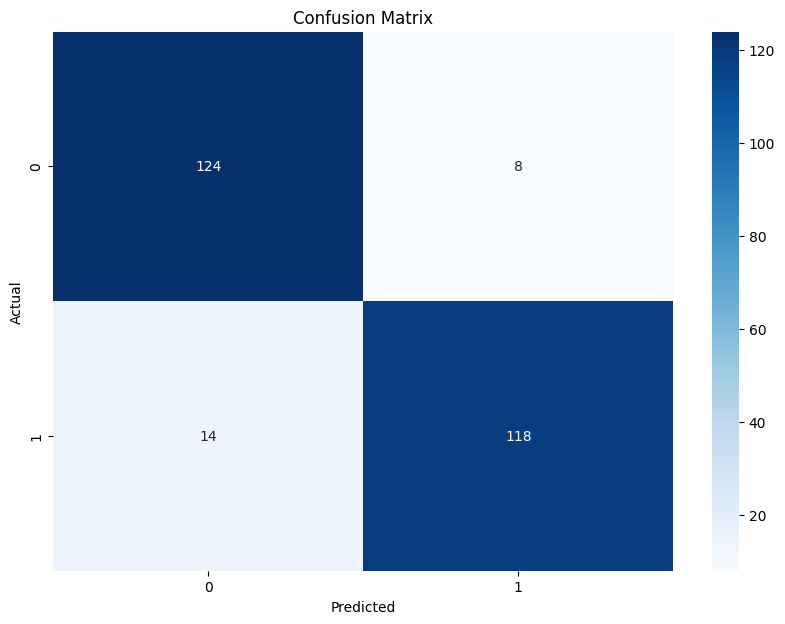

Precision: 0.9365079365079365
Recall: 0.8939393939393939
F1 Score: 0.9147286821705426


In [8]:
# Print metrics
print(f"Train Accuracy: {train_acc}")
print(f"Train Loss: {train_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
print('')
print("Confusion Matrix:")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate additional metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Print metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [9]:
# Save the trained model
model_path = r'C:\Users\Flavio Ruvalcaba\Documents\Escuela\Universidad\8Semestre\PlagiarismDetectorApp\model\xgboost_model.pkl'
joblib.dump(model, model_path)

['C:\\Users\\Flavio Ruvalcaba\\Documents\\Escuela\\Universidad\\8Semestre\\PlagiarismDetectorApp\\model\\xgboost_model.pkl']

In [10]:
# Function to test the model using external files
def test_model_on_external_files(file1_path, file2_path, model_path, tfidf_vectorizer):
    model = joblib.load(model_path)
    
    def read_java_file(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return content

    def extract_ast_nodes(code):
        try:
            tokens = list(javalang.tokenizer.tokenize(code))
            parser = javalang.parser.Parser(tokens)
            tree = parser.parse()

            ast_nodes = []
            for path, node in tree:
                if isinstance(node, javalang.tree.Node):
                    ast_nodes.append(node.__class__.__name__)
            return ' '.join(ast_nodes)
        except (javalang.parser.JavaSyntaxError, javalang.tokenizer.LexerError) as e:
            print(f"Error parsing Java code: {e}")
            return ''

    code1 = read_java_file(file1_path)
    code2 = read_java_file(file2_path)
    ast_nodes1 = extract_ast_nodes(code1)
    ast_nodes2 = extract_ast_nodes(code2)

    if ast_nodes1 and ast_nodes2:
        combined_ast_nodes = ast_nodes1 + ' ' + ast_nodes2
        combined_features = tfidf_vectorizer.transform([combined_ast_nodes])
        
        ast_set1 = set(ast_nodes1.split())
        ast_set2 = set(ast_nodes2.split())

        # Calculate additional features
        jaccard_similarity = len(ast_set1.intersection(ast_set2)) / len(ast_set1.union(ast_set2)) if len(ast_set1.union(ast_set2)) != 0 else 0
        vec1 = tfidf_vectorizer.transform([ast_nodes1]).toarray()[0]
        vec2 = tfidf_vectorizer.transform([ast_nodes2]).toarray()[0]
        manhattan_distance = np.sum(np.abs(vec1 - vec2))

        # Combine all features
        additional_features = np.array([[manhattan_distance, jaccard_similarity]])
        combined_features = np.hstack((combined_features.toarray(), additional_features))

        # Predict using the model
        prediction = model.predict(combined_features)
        return prediction[0]
    else:
        print("Error: AST extraction failed for one or both files.")
        return None

In [11]:
# Example usage of the test function
file1 = r'C:\Users\Flavio Ruvalcaba\Documents\Escuela\Universidad\8Semestre\PlagiarismDetector\Modeling\TestFiles\case-04\original\T4.java'
file2 = r'C:\Users\Flavio Ruvalcaba\Documents\Escuela\Universidad\8Semestre\PlagiarismDetector\Modeling\TestFiles\case-04\non-plagiarized\01\T04.java'
result = test_model_on_external_files(file1, file2, model_path, tfidf_vectorizer)
print(f"Prediction for the external files: {result}")

Prediction for the external files: 0
